In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.linear_model import LinearRegression, LogisticRegression
import warnings
warnings.filterwarnings('ignore')

/var/folders/fl/wxh0fmxj54nfxl1pmyp76jv80000gn/T/ipykernel_90253/525985860.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Part 2: How should we deal with causality?

## Low dimensional settings
When statisticians talk about bias, adjustment is often the go-to solution. When you have a **low dimensional dataset**, *i.e.*, you only have a limited number of features, it is often possible to adjust for confounding variables. This is done by either stratifying (taking the average of the effects X on Y over each of the confounding groups) or by including the confounder variable in the model. 

For example, if you are interested in the effect of a gene expression on a survival rate, as in [Uhlen *et al.*, 2018](https://www.science.org/doi/10.1126/science.aan2507?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed), you might want to adjust for the age of the patient, as older patients are more likely to die sooner<sup>*</sup>.

<sup>*</sup> Interestingly, Uhlen *et al.* did not adjust for age in their 2018 Science publication. A highly interesting critical review of their methods can be found [here](https://www.biorxiv.org/content/10.1101/2020.03.16.994038v2).

### Experiment 3: adjusting for confounding variables
The dataset in `data/transcriptomics_pathology.csv` contains metadata and gene expression data on 10 genes for 1000 patients:

In [3]:
data = pd.read_csv('..//data/transcriptomics_pathology.csv', index_col=0)
data.head()

,Age,Gender,Gene_1 expression,Gene_2 expression,Survival Years
Patient 1,Young,Woman,0.126586,0.883764,24
Patient 2,Old,Man,1.186966,0.329328,14
Patient 3,Young,Woman,0.180942,0.745151,65
Patient 4,Old,Man,0.695649,0.429752,16
Patient 5,Young,Man,0.189464,0.312411,60


Assuming the two genes' expression levels are independent from each other, but confounded by the age of the patient, build a correctly adjusted linear model to find out which gene(s) likely have a causal effect on the survival rate.

In [5]:
# specify below which variables you want to include in the model
vars_to_include = ['Gene_1 expression', 'Gene_2 expression', 'Age', 'Gender']

# formatting dummy variables
data['Age'].replace(['Young', 'Old'], [0, 1], inplace=True)
data['Gender'].replace(['Man', 'Woman'], [0, 1], inplace=True)

# linear model
lm = LinearRegression()
lm.fit(data.loc[:, vars_to_include], data['Survival Years'])
print(
    """
    Gene 1's expression has an impact on survival with coefficient {},
    Gene 2's expression has an impact on survival with coefficient {}
    """.format(round(lm.coef_[0], 2), round(lm.coef_[1], 2))
    )


    Gene 1's expression has an impact on survival with coefficient -0.73,
    Gene 2's expression has an impact on survival with coefficient -17.18
    


You can quickly check the difference this makes in coefficients when you don't adjust for the age of the patient.

### Experiment 4: All for adjustment, and adjustment for all
While adjustment is a step in the right direction, *i.e.*, the one that acknowledges causality, it can sometimes do more harm than good.

Consider the following example:
**Effects of a New Drug on Blood Pressure**

Imagine a clinical trial testing the efficacy of a new drug designed to lower blood pressure in hypertensive patients. The DAG for this scenario might look like this:

- Treatment: Represents whether a patient received the new drug (e.g., Drug X) or a placebo.
- Blood Pressure: Represents the primary outcome variable, the patient's blood pressure measurement.
- Age: Represents the patient's age, a potential confounding variable associated with both the treatment assignment and blood pressure.
- Exercise: Represents whether the patient regularly partakes in physical activity, which could affect blood pressure independently of the treatment.
- Cholesterol: Represents the cholesterol level of the patient after receiving the treatment. This may impact blood pressure as well.

In [7]:
data = pd.read_csv('../data/blood_pressure.csv', index_col=0)
data.head()

,Treatment,Age,Exercise,Cholesterol,Blood Pressure
Patient 1,Placebo,Young,0,179.690255,109.732353
Patient 2,Treatment,Old,1,168.880741,124.321006
Patient 3,Placebo,Young,0,183.684529,113.626123
Patient 4,Treatment,Young,0,146.573601,97.656936
Patient 5,Placebo,Young,0,196.820208,118.844416


Which variables should you include in your model to estimate the causal effect of the treatment on blood pressure? How does including them influence the coefficient of the treatment variable?

In [9]:
# specify below which variables you want to include in the model
vars_to_include = ['Treatment', 'Age', 'Exercise', 'Cholesterol']

# formatting dummy variables
data['Age'].replace(['Young', 'Old'], [0, 1], inplace=True)
data['Treatment'].replace(['Placebo', 'Treatment'], [0, 1], inplace=True)

# linear model
lm = LinearRegression()
lm.fit(data.loc[:, vars_to_include], data['Blood Pressure'])
print(
    """
    The treatment has an impact on blood pressure with coefficient {},
    age has an impact on blood pressure with coefficient {},
    exercise has an impact on blood pressure with coefficient {}
    """.format(round(lm.coef_[0], 2), round(lm.coef_[1], 2), round(lm.coef_[2], 2))
    )


    The treatment has an impact on blood pressure with coefficient 1.53,
    age has an impact on blood pressure with coefficient 8.08,
    exercise has an impact on blood pressure with coefficient -3.01
    


**Cheatcode:** There is a very handy site called [daggity](http://www.dagitty.net/dags.html) that allows you to draw causal diagrams and check which variables you should adjust for in your analysis. It even allows you to draw in unobserved variables that you know are important, but you can't measure.

## High dimensional settings
When you have a large number of features in your dataset, it can become near-to impossible to construct a DAG of all interactions between the features. Though you could select a subset of features that you do know the interactions for, you might risk exclusion of important confounders. This is where the field of causal machine learning comes in.

There are many different methodologies in causal ML, but they all have the same goal: to estimate the causal effect of a treatment on an outcome. For the sake of this session, we will focus on one of the most popular methods: the Augmented Inverse Probability Weighted estimator (AIPW). This method is a doubly robust estimator, meaning that it is consistent if either the treatment model or the outcome model is correctly specified.

### Experiment 5:  causal machine learning
For this example, we will work on the Lindner dataset, an observational study of 996 patients receiving an initial Percutaneous Coronary Intervention (PCI) at Ohio Heart Health, Christ Hospital, Cincinnati in 1997 and followed for at least 6 months by the staff of the Lindner Center (source: [Kereiakes *et al.*, 2000](https://doi.org/10.1067/mhj.2000.109647)).


In [10]:
data = pd.read_csv('../data/lindner.csv', index_col=0)
data.head()

,PCI care,Stent,Height,Female,Diabetic,Myocardial infarction,Ejection fraction,Vessels,Died
1,1,0,163,1,1,0,56,1,1
2,1,0,168,0,0,0,56,1,0
3,1,0,188,0,0,0,50,1,0
4,1,0,175,0,1,0,50,1,0
5,1,0,168,1,0,0,55,1,0


The dataset contains the following columns:
- PCI care (treatment): whether or not the patient received a Percutaneous Coronary Intervention (PCI)
- Stent: deployment of a coronary stent
- Height: height of the patient in centimeters
- Female: whether the patient was female
- Diabetic: whether the patient was diabetic
- Myocardial infarction: whether the patient had an acute myocardial infarction within the previous 7 days
- Ejection fraction: the left ventricle ejection fraction of the patient
- Vessels: the number of vessels involved in the patient's initial PCI procedure
- Died (outcome): whether or not the patient died within 6 months of the procedure

As this is just an observational study (and not a randomized controlled trial), patients received the treatment based on decision by the MD. We first build the propensity model, which estimates the probability of receiving the treatment given the observed covariates:

$g(L) = \hat{E}[A=1|L]$

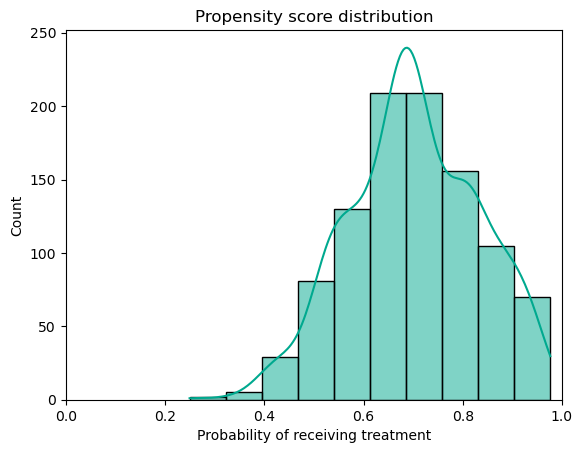

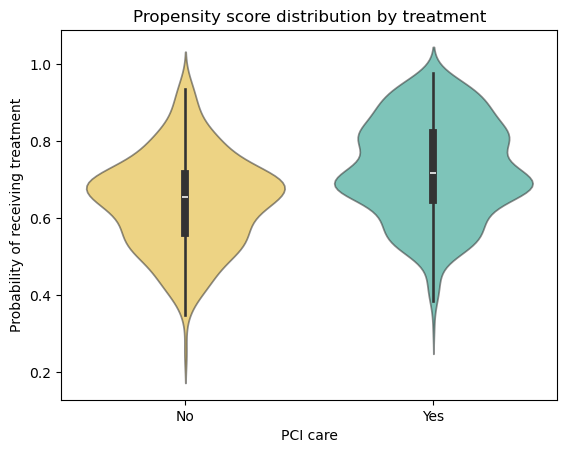

0.2493502106632051 0.9766029080810934


In [12]:
# set key variables
A = data['PCI care'] # exposure A
Y = data['Died'] # outcome Y
L = data.loc[
    :,
    ['Stent', 'Height', 'Female', 'Diabetic', 'Myocardial infarction', 'Ejection fraction', 'Vessels']
    ] # covariates L

# odds of receiving treatment Ê[A|L] (for simplicity, we use a logistic regression model, but you can use any model)
g = LogisticRegression(random_state=42)
g.fit(L, A)
treatment_propensity = g.predict_proba(L)[:, 1]

# visualize this in a histogram and violinplot
ax = sb.histplot(treatment_propensity, kde=True, color="#00A98F", bins=10)
ax.set(
    xlabel='Probability of receiving treatment',
    title='Propensity score distribution'
    )
ax.set_xlim(0, 1)
#plt.savefig('./figures/propensity_score_histogram.png')
plt.show()

ax2 = sb.violinplot(x=A, y=treatment_propensity, palette={'0':"#FFC000", '1':"#00A98F"}, alpha=0.55)
ax2.set(
    xlabel='PCI care',
    xticklabels=['No', 'Yes'],
    ylabel='Probability of receiving treatment',
    title='Propensity score distribution by treatment'
    )
#plt.savefig('./figures/propensity_score_violinplot.png')
plt.show()
print(min(treatment_propensity), max(treatment_propensity))

It seems that most patients were actually fairly likely to receive this treatment given their state (as represented in the covariates). Given the context of the dataset, this makes sense. In a Randomized Controlled Trial however, propensity should be evenly distributed between the treatment and control groups.

Secondly, we build the outcome model, which estimates the probability of dying within 6 months given the observed covariates. Finally, we use the AIPW estimator to estimate the causal effect of the treatment on the outcome:

$Q^{(0)}(L) = \hat{E}[Y|A=0, L]$

In [14]:
# set key variables
X = data.loc[
    :,
    ['PCI care', 'Stent', 'Height', 'Female', 'Diabetic', 'Myocardial infarction', 'Ejection fraction', 'Vessels']
    ] # covariates including exposure

# odds of dying within 6 months Ê[Y|L] (for simplicity, we use a logistic regression model, but you can use any model)
Q = LogisticRegression(random_state=42)
Q.fit(X, Y)

# predicted counterfactual outcomes under treatment
X_all_treated = X.copy(); X_all_treated['PCI care'] = 1
Q1 = Q.predict_proba(X_all_treated)[:, 1]

# predicted counterfactual outcomes under no treatment
X_none_treated = X.copy(); X_all_treated['PCI care'] = 0
Q0 = Q.predict_proba(X_none_treated)[:, 1]

We can then calculate the Average Treatment Effect (ATE) by weighing predicted outcomes under each counterfactual treatment by the probability of receiving the treatment:

In [15]:
# E[Y^1]
Y1 = np.divide(A, treatment_propensity) * (Y - Q1) + Q1
EY1 = np.mean(Y1)

# E[Y^0]
Y0 = np.divide((1-A),(1-treatment_propensity)) * (Y - Q0) + Q0
EY0 = np.mean(Y0)

In [18]:
EY1

0.015410050296493633

In [19]:
# quickly calculating standard errors and confidence intervals
eic_EY1 = np.divide(A, treatment_propensity) * (Y - Q1) + Q1 - EY1
eic_EY0 = np.divide((1-A),(1-treatment_propensity)) * (Y - Q0) + Q0 - EY0
se_EY1 = (1/np.sqrt(len(Y))) * np.std(eic_EY1)
se_EY0 = (1/np.sqrt(len(Y))) * np.std(eic_EY0)
ci_high_EY1 = EY1 + 1.96 * se_EY1; ci_low_EY1 = EY1 - 1.96 * se_EY1
ci_high_EY0 = EY0 + 1.96 * se_EY0; ci_low_EY0 = EY0 - 1.96 * se_EY0

# printing results
print(
    """
    The estimated odds of dying within 6 months under treatment are {}% (CI 95%: {}-{})
    """.format(round(EY1, 4) * 100, round(ci_low_EY1, 4) * 100, round(ci_high_EY1, 4) * 100),
    )
print(
    """
    The estimated odds of dying within 6 months without treatment are {}%  (CI 95%: {}-{})
    """.format(round(EY0, 4) * 100, round(ci_low_EY0, 4) * 100, round(ci_high_EY0, 4) * 100),
    )
print(
    """
    Treatment thus reduces the odds of dying within 6 months by {}%.
    """.format(-round(EY1-EY0, 4) * 100)
    )


    The estimated odds of dying within 6 months under treatment are 1.54% (CI 95%: 0.62-2.46)
    

    The estimated odds of dying within 6 months without treatment are 4.99%  (CI 95%: 0.15-9.84)
    

    Treatment thus reduces the odds of dying within 6 months by 3.45%.
    


Now let's compare to a non-causally informed machine learning model, which does not account for the confounding or colliding variables.

In [20]:
# straight-forward logistic regression
clf = LogisticRegression(random_state=42)
clf.fit(X, Y)

print(
    """
    According to the logistic regression model, the odds of dying within 6 months are increased by {}% when receiving treatment
    """.format(round(clf.coef_[0][0], 2))
)


    According to the logistic regression model, the odds of dying within 6 months are increased by -1.27% when receiving treatment
    
